# Orthorectification Tutorial with Orbview 3 data
For this tutorial we'll orthorectify an Orbview 3 scene. This scene data is available here: https://github.com/WalidGharianiEAGLE/orthorectification_python_tutorial/tree/master/orbview3_data

Just grab it and unzip it in the same working directory as this notebook

### First we import a bunch of stuff

In [1]:
from orthorectification.visualization_tools import (
    rescale_elevation_data,
    overlay_polygon,
    reproject_with_affine
)

from orthorectification.ortho_tools import make_ortho, unpack_rpc_parameters
from orthorectification.scaling_tools import gaussian_rescale
from orthorectification.io_tools import save_raster_as_geotiff
from PIL import Image

import numpy as np
import cv2
import warnings

import pyproj
import shapely
from shapely.ops import transform

import os
import gdal
import re

from typing import Tuple, Dict

import json
from osgeo import ogr

warnings.filterwarnings("ignore")

### Read some data!

In [2]:
gdal.AllRegister()
orbview_dataset = gdal.Open("./3v050905m0000880351a520001100172m_001659557.tif")
rpc_dict = orbview_dataset.GetMetadata_Dict("RPC")

### Wrangle the RPC data into a form that our library is comfortable with

In [3]:
# We have units and also weird things like leading 0s in the RPC dict. :(
# Example: 
rpc_dict["HEIGHT_OFF"]

'+0576.000 meters'

In [4]:
# We have to strip out non-numeric elements...
# This regex expression will strip out anything that isn't a digit, a period, the letter "E", a hyphen, or whitespace
rpc_dict_repaired = {
    key: re.sub("[^0-9\-.\sE]", "", value) for key, value in rpc_dict.items()
}

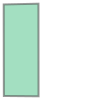

In [5]:
# We are also missing MIN_LON, MAX_LON, MIN_LAT, MAX_LAT -- these are important. I think we can easily get it from the associated
# metadata. There's a shapefile in here that looks like a good lead. We can use OGR to read it, json to parse it, and shapely to
# wrangle / display it

file = ogr.Open("3v050905m0000880351a520001100172m_001659557.shp")
shape = file.GetLayer(0)
# first feature of the shapefile
feature = shape.GetFeature(0)
image_footprint = json.loads(feature.ExportToJson())
image_footprint = shapely.geometry.Polygon(
    image_footprint["geometry"]["coordinates"][0]
)
image_footprint

In [6]:
lons = image_footprint.exterior.coords.xy[0]
lats = image_footprint.exterior.coords.xy[1]
rpc_dict_repaired["MIN_LONG"] = min(lons)
rpc_dict_repaired["MAX_LONG"] = max(lons)
rpc_dict_repaired["MIN_LAT"] = min(lats)
rpc_dict_repaired["MAX_LAT"] = max(lats)

In [7]:
image_footprint.exterior.coords.xy

(array('d', [11.9729301, 12.0902266, 12.0905223, 11.973425, 11.9729301]),
 array('d', [48.0395436, 48.0420951, 47.7294953, 47.730581, 48.0395436]))

In [8]:
rpcs = unpack_rpc_parameters(rpc_dict_repaired)
rpcs

RPCCoeffs(height_off=576.0, height_scale=899.0, lat_off=47.8853, lat_scale=0.1624, line_den_coeff=array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32), line_num_coeff=array([ 2.0447569e-03,  8.7323515e-03, -1.0388674e+00,  2.5473462e-02,
        4.4312730e-04, -3.8225512e-06, -6.1674882e-04, -1.4854626e-04,
       -6.9108796e-03,  1.5241248e-05,  1.5670701e-06,  3.0545655e-07,
       -1.8318180e-05, -2.0188997e-08, -1.8737398e-07,  8.1986633e-05,
       -4.2984786e-07, -1.2971032e-07, -9.5150262e-06, -2.5407939e-08],
      dtype=float32), line_off=3584.0, line_scale=3584.0, long_off=12.0316, long_scale=0.06, max_lat=48.0420951, max_long=12.0905223, min_lat=47.7294953, min_long=11.9729301, samp_den_coeff=array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32), samp_num_coeff=array([-1.2089121e-03,  1.0196927e+00, -3.8999840e-04, -1.5612319e-02,
        2.7270939e-03,  1.9875683

### Rescale and convert the data

We'll use a Gaussian rescale routine for this. I think most sensors are 11 or 12 bit. That means that its maximum intensity value for any given pixel at any given band is either 2047 (2^11 - 1) or 4095 (2^12 - 1). It is then jammed into 16-bit unsigned short arrays despite never having pixel
intensities that go up to what a 16-bit unsigned short can represent (2^16 - 1 or 65535). 

In [9]:
pixel_data = orbview_dataset.ReadAsArray()
display(pixel_data.max())

2047

So it's 11 bit

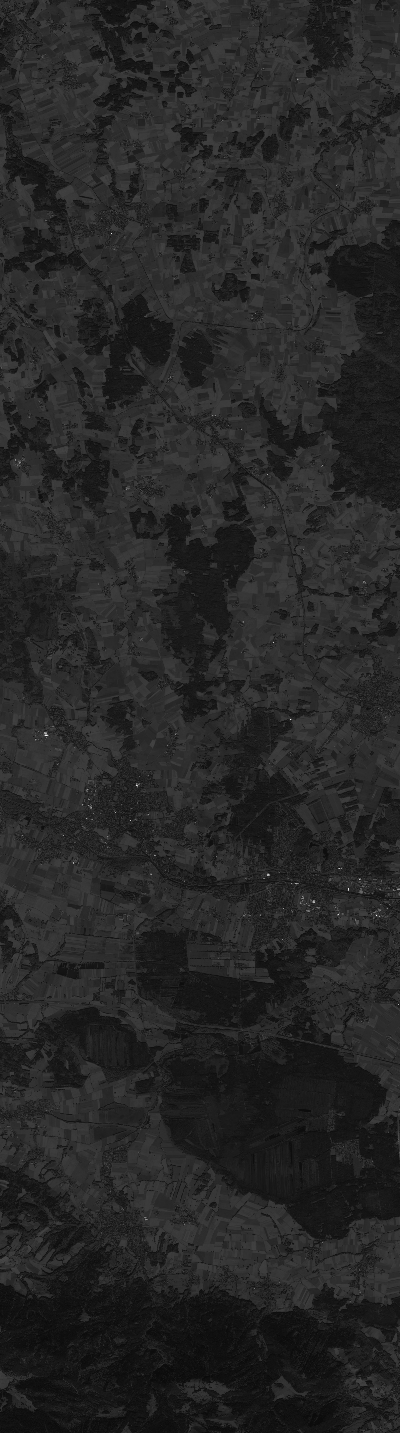

In [10]:
single_channel = pixel_data.mean(axis=0)
rescaled_img = gaussian_rescale(single_channel, bitness=11).astype(np.uint8)
# Let's take a look at it downsampled by a factor of 5
resized = cv2.resize(
    rescaled_img, (int(rescaled_img.shape[1] / 5), int(rescaled_img.shape[0] / 5))
)
Image.fromarray(resized)

### Grab some elevation data oriented around the scene
I like using this SARDEM library but you can really use anything...

In [11]:
!createdem 11 49 2 2  --data-source AWS --output elevation.dem

[12/15 12:26:22] [INFO dem.py] Bounds: 11.0 47.0 13.0 49.0
[12/15 12:26:22] [INFO dem.py] /home/mpfaffenberger/.cache/sardem/N48E011.hgt already exists, skipping.
[12/15 12:26:22] [INFO dem.py] /home/mpfaffenberger/.cache/sardem/N47E012.hgt already exists, skipping.
[12/15 12:26:22] [INFO dem.py] /home/mpfaffenberger/.cache/sardem/N48E012.hgt already exists, skipping.
[12/15 12:26:22] [INFO dem.py] /home/mpfaffenberger/.cache/sardem/N47E011.hgt already exists, skipping.
/home/mpfaffenberger/anaconda3/envs/rapids/lib/python3.7/site-packages/sardem/dem.py:562: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  cur_row = np.hstack(self._load_tile(tile_name) for tile_name in row)
[12/15 12:26:22] [INFO dem.py] Cropping stitched DEM to boundaries
[12/15 12:26:22] [INFO dem.py] Rate = 1: No upsampling to do
[12/15 12:26:22] [INFO

### Visualize the DEM and make sure that it covers our scene

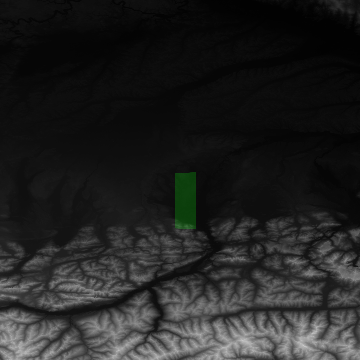

In [12]:
dem_ds = gdal.Open("elevation.dem")
dem_geo_t = dem_ds.GetGeoTransform()
raw_dem_data = dem_ds.ReadAsArray()
# make a separate copy of the dem data for display
dem_vis = rescale_elevation_data(raw_dem_data).astype(np.uint8)
# We can reproject the image footprint from lon/lat coordinates to the image coordinates of the DEM tile
image_footprint_dem = reproject_with_affine(image_footprint.exterior.coords, dem_geo_t)
image_footprint_dem = shapely.geometry.Polygon(image_footprint_dem)
# Burn a transparent polygon representing the image footprint onto the DEM data.
burn_in = overlay_polygon(dem_vis, image_footprint_dem)
resized_vis_dem = cv2.resize(
    burn_in, (int(burn_in.shape[1] / 20), int(burn_in.shape[0] / 20))
)
Image.fromarray(resized_vis_dem)

Absolutely beautiful. Now we can be sure that the imagery will match up with the DEM.

### Make the final ortho

In [15]:
img_data_warped, gsd, ul_lon, ul_lat = make_ortho(
    min(lons), 
    max(lons),
    min(lats), 
    max(lats),
    5000, # picking a very large size for nice interpolation detail
    rescaled_img,
    rpcs,
    raw_dem_data,
    dem_geo_t
)

In [16]:
save_raster_as_geotiff(img_data_warped.astype(np.uint8), ul_lon, ul_lat, gsd, "ortho_scene.tif")